In [1]:
import os
import shap
from shap.plots import colors  
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lang2vec.lang2vec as l2v
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import plot_tree
from joblib import Parallel, delayed
from scipy.stats import pearsonr, zscore
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances

# For plots with LaTeX, might give issues depending on your local LaTeX installation
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{bm}',
    'font.family': 'serif',
})

In [2]:
language_map = {
    "same": "English",
    "avg": "Average",
    "af": "Afrikaans",
    "ar": "Arabic",
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "es": "Spanish",
    "fa": "Persian",
    "fi": "Finnish",
    "fr": "French",
    "he": "Hebrew",
    "hi": "Hindi",
    "hu": "Hungarian",
    "it": "Italian",
    "ja": "Japanese",
    "ko": "Korean",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "no": "Norwegian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "sv": "Swedish",
    "ta": "Tamil",
    "th": "Thai",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
    "zh": "Chinese",
    "sw": "Swahili",
    "ur": "Urdu",
    "en": "English"
}

In [3]:
method_names = {
    'baseline': 'Fine-tuning Only',
    'before_fastalign': 'Before FastAlign',
    'before_awesome': 'Before Awesome',
    'before_dico': 'Before Dict',
    'during_fastalign': 'During FastAlign',
    'during_awesome': 'During Awesome',
    'during_dico': 'During Dict',
    'freeze_realign_unfreeze_fastalign': 'Before - Front Freeze FastAlign',
    'freeze_realign_unfreeze_awesome': 'Before - Front Freeze Awesome',
    'freeze_realign_unfreeze_dico': 'Before - Front Freeze Dict',
    'freeze_realign_unfreeze_last_6_fastalign': 'Before - Back Freeze FastAlign',
    'freeze_realign_unfreeze_last_half_fastalign': 'Before - Back Freeze FastAlign',
    
    'freeze_realign_unfreeze_last_6_awesome': 'Before - Back Freeze Awesome',
    'freeze_realign_unfreeze_last_half_awesome': 'Before - Back Freeze Awesome',

    'freeze_realign_unfreeze_last_6_dico': 'Before - Back Freeze Dict',
    'freeze_realign_unfreeze_last_half_dico': 'Before - Back Freeze Dict',

    'during_partial_freeze_front_fastalign': 'During Front Freeze FastAlign',
    'during_partial_freeze_front_awesome': 'During Front Freeze Awesome',
    'during_partial_freeze_front_dico': 'During Front Freeze Dict',
    'during_partial_freeze_back_fastalign': 'During Back Freeze FastAlign',
    'during_partial_freeze_back_awesome': 'During Back Freeze Awesome',
    'during_partial_freeze_back_dico': 'During Back Freeze Dict',
}

In [4]:
lang2vec_mapping = {
    "English": "eng",
    "Afrikaans": "afr",
    "Arabic": "arb",
    "Bulgarian": "bul",
    "Catalan": "cat",
    "Czech": "ces",
    "Danish": "dan",
    "German": "deu",
    "Greek": "ell",
    "Spanish": "spa",
    "Persian": "fas",
    "Finnish": "fin",
    "French": "fra",
    "Hebrew": "heb",
    "Hindi": "hin",
    "Hungarian": "hun",
    "Italian": "ita",
    "Japanese": "jpn",
    "Korean": "kor",
    "Lithuanian": "lit",
    "Latvian": "lav",
    "Norwegian": "nob",
    "Polish": "pol",
    "Portuguese": "por",
    "Romanian": "ron",
    "Russian": "rus",
    "Slovak": "slk",
    "Slovenian": "slv",
    "Swedish": "swe",
    "Tamil": "tam",
    "Thai": "tha",
    "Turkish": "tur",
    "Ukrainian": "ukr",
    "Vietnamese": "vie",
    "Chinese": "cmn"
}

In [5]:
def get_lang_distances(lang1, lang2, mapping):
    if lang1 == 'English' and lang2 == 'English':
        return {'syntactic': 0, 'geographic': 0, 'phonological': 0, 'genetic': 0, 'inventory': 0, 'featural': 0}
    lang2_code = mapping.get(lang2)
    
    if not lang2_code:
        print(f"Error: {lang2} is not in the language mapping.")
        return {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    try:
        distances = {
            'syntactic': l2v.distance('syntactic', lang1, lang2_code),
            'geographic': l2v.distance('geographic', lang1, lang2_code),
            'phonological': l2v.distance('phonological', lang1, lang2_code),
            'genetic': l2v.distance('genetic', lang1, lang2_code),
            'inventory': l2v.distance('inventory', lang1, lang2_code),
            'featural': l2v.distance('featural', lang1, lang2_code),
        }
    except Exception as e:
        print(f"Error calculating distances between {lang1} and {lang2_code}: {e}")
        distances = {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    return distances

In [6]:
def add_language_distances_to_df(df, target_lang='eng', lang_col='language'):
    # Initialize distance columns
    distance_cols = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']
    for col in distance_cols:
        df[col] = np.nan

    for lang in df[lang_col].unique():
        distances = get_lang_distances(target_lang, lang, lang2vec_mapping)
        for col, value in distances.items():
            df.loc[df[lang_col] == lang, col] = value
    
    return df

In [7]:
csv_file_path = './distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv'

def read_and_process_csv(file_path, model_name):
    df = pd.read_csv(file_path)
    records = []
    
    for idx, row in df.iterrows():
        method = row['method']
        seed = row['seed']
        for lang in language_map.keys():
            accuracy_key = f'eval_{lang}_accuracy'
            if accuracy_key in df.columns:
                accuracy = row[accuracy_key]
                record = {
                    'model': model_name,
                    'method': method_names.get(method, method),
                    'language': language_map.get(lang, lang),
                    'seed': seed,
                    'accuracy': accuracy if not pd.isna(accuracy) else None
                }
                records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

distilmbert_df = read_and_process_csv(csv_file_path, model_name='distilMBERT')


In [8]:
def calculate_delta_accuracy(group):
    baseline = group[group['method'] == 'Fine-tuning Only']
    methods = group[group['method'] != 'Fine-tuning Only']
    
    if len(baseline) > 0:
        baseline_accuracy = baseline['accuracy'].values
        
        for method in methods['method'].unique():
            method_indices = methods['method'] == method
            baseline_subset = baseline_accuracy[:sum(method_indices)]
            methods.loc[method_indices, 'delta_accuracy'] = methods.loc[method_indices, 'accuracy'].values - baseline_subset

    return pd.concat([baseline, methods])

def process_dataframe(df, group_by_columns):
    result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
    return result.reset_index(drop=True)

In [9]:
with open("token_counts.txt") as f:
    distilmbert_counts = f.readlines()

# Process distilmbert token data
distilmbert_token_data = {}
for line in distilmbert_counts:
    parts = line.split(':')
    if len(parts) == 2:
        language = parts[0].split('(')[0].strip()
        count = int(parts[1].strip())
        distilmbert_token_data[language] = count

def bin_token_counts(tokens):
    if tokens < 300_000_000:
        return 'Very Low (Less Than 300M)'
    elif tokens < 1_000_000_000:
        return 'Low (300M-1B)'
    elif tokens < 2_000_000_000:
        return 'Medium (1B-2B)'
    elif tokens < 5_000_000_000:
        return 'High (2B-5B)'
    else:
        return 'Very High (More Than 5B)'

def add_token_counts(df):
    df = df.copy()
    df['token_count'] = df['language'].map(distilmbert_token_data)
    df['token_bin'] = df['token_count'].apply(bin_token_counts)
    
    nan_rows = df[df['token_bin'].isna()]
    if not nan_rows.empty:
        print("Languages with NaN token bins:")
        for _, row in nan_rows.iterrows():
            print(f"Model: {row['model']}, Language: {row['language']}")
    
    return df

In [10]:
df = process_dataframe(distilmbert_df, group_by_columns=['model', 'seed', 'language'])
df

C:\Users\alith\AppData\Local\Temp\ipykernel_314948\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


,model,method,language,seed,accuracy,delta_accuracy
0,distilMBERT,Fine-tuning Only,Afrikaans,17,0.852558,NaN
1,distilMBERT,Before FastAlign,Afrikaans,17,0.866965,0.014406
2,distilMBERT,Before Awesome,Afrikaans,17,0.865176,0.012618
3,distilMBERT,Before Dict,Afrikaans,17,0.854645,0.002086
4,distilMBERT,During FastAlign,Afrikaans,17,0.862394,0.009836
...,...,...,...,...,...,...
3415,distilMBERT,During Back Freeze Awesome,Vietnamese,66,0.569218,-0.010874
3416,distilMBERT,During Back Freeze Dict,Vietnamese,66,0.586951,0.006859
3417,distilMBERT,Before - Back Freeze FastAlign,Vietnamese,66,0.570724,-0.009368
3418,distilMBERT,Before - Back Freeze Awesome,Vietnamese,66,0.576746,-0.003346


In [11]:
# Drop rows with NaNs in 'accuracy' column
df.dropna(subset=['accuracy'], inplace=True)

# Drop rows with NaNs in 'delta_accuracy' column (if applicable)
df.dropna(subset=['delta_accuracy'], inplace=True)

df.drop('model', axis=1, inplace=True)

df.drop('accuracy', axis=1, inplace=True)

df.drop('seed', axis=1, inplace=True)

df

,method,language,delta_accuracy
1,Before FastAlign,Afrikaans,0.014406
2,Before Awesome,Afrikaans,0.012618
3,Before Dict,Afrikaans,0.002086
4,During FastAlign,Afrikaans,0.009836
5,During Awesome,Afrikaans,0.011823
...,...,...,...
3415,During Back Freeze Awesome,Vietnamese,-0.010874
3416,During Back Freeze Dict,Vietnamese,0.006859
3417,Before - Back Freeze FastAlign,Vietnamese,-0.009368
3418,Before - Back Freeze Awesome,Vietnamese,-0.003346


In [12]:
df = df[~df['method'].str.contains('During', na=False)]
df['method'].value_counts()

method
Before FastAlign                   180
Before Awesome                     180
Before Dict                        180
Before - Front Freeze FastAlign    180
Before - Front Freeze Awesome      180
Before - Front Freeze Dict         180
Before - Back Freeze FastAlign     180
Before - Back Freeze Awesome       180
Before - Back Freeze Dict          180
Name: count, dtype: int64

In [13]:
def split_method_column(df):
    # Create new columns
    df['aligner'] = ''
    df['frozen_status'] = ''
    df['freeze_location'] = 'None'  # Default to 'None'

    # Define mapping for aligners
    aligner_map = {
        'FastAlign': 'FastAlign',
        'Awesome': 'Awesome',
        'Dict': 'Dict'
    }

    # Split the method column
    for idx, row in df.iterrows():
        method = row['method']
        
        # Extract aligner
        for key, value in aligner_map.items():
            if key in method:
                df.at[idx, 'aligner'] = value
                break
        
        # Determine frozen status and location
        if 'Freeze' in method:
            df.at[idx, 'frozen_status'] = 'Frozen'
            if 'Front' in method:
                df.at[idx, 'freeze_location'] = 'Front'
            elif 'Back' in method:
                df.at[idx, 'freeze_location'] = 'Back'
        else:
            df.at[idx, 'frozen_status'] = 'Vanilla'
            # freeze_location remains 'None' for non-frozen methods
    
    # Drop the original 'method' column
    df = df.drop('method', axis=1)
    
    return df

# Apply the function to the main dataframe
df = split_method_column(df)

# Display the updated dataframe
df.head()

C:\Users\alith\AppData\Local\Temp\ipykernel_314948\3144977145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligner'] = ''
C:\Users\alith\AppData\Local\Temp\ipykernel_314948\3144977145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frozen_status'] = ''
C:\Users\alith\AppData\Local\Temp\ipykernel_314948\3144977145.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,language,delta_accuracy,aligner,frozen_status,freeze_location
1,Afrikaans,0.014406,FastAlign,Vanilla,None
2,Afrikaans,0.012618,Awesome,Vanilla,None
3,Afrikaans,0.002086,Dict,Vanilla,None
7,Afrikaans,0.011128,FastAlign,Frozen,Front
8,Afrikaans,0.011227,Awesome,Frozen,Front


In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42)


def split_train_val_test(df, test_size=0.2, val_size=0.1, random_state=42):
    # First, split into train+val and test
    train_val, test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Then split train+val into train and val
    val_size_adjusted = val_size / (1 - test_size)
    train, val = train_test_split(train_val, test_size=val_size_adjusted, random_state=random_state)
    
    return train, val, test

# df = add_token_counts(df)
# df.drop('token_count', axis=1, inplace=True)

# Usage
train_data, val_data, test_data = split_train_val_test(df)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)


# def split_train_val_test(combined_data, use_standard_split=False, exclude_languages=False, test_size=0.2, val_size=0.1, random_state=42):
#     combined_data = combined_data.drop(columns=['accuracy'])

#     if use_standard_split:
#         if exclude_languages:
#             # Get a list of unique languages
#             languages = combined_data['language'].unique()
#             # Randomly choose languages to exclude from the training set
#             val_test_languages = np.random.choice(languages, size=int(len(languages) * (val_size + test_size)), replace=False)
#             val_languages = val_test_languages[:int(len(val_test_languages) * (val_size / (val_size + test_size)))]
#             test_languages = val_test_languages[int(len(val_test_languages) * (val_size / (val_size + test_size))):]
            
#             # Split data accordingly
#             train_data = combined_data[~combined_data['language'].isin(val_test_languages)]
#             val_data = combined_data[combined_data['language'].isin(val_languages)]
#             test_data = combined_data[combined_data['language'].isin(test_languages)]
#         else:
#             # Perform a standard train-validation-test split
#             train_data, temp_data = train_test_split(combined_data, test_size=(test_size + val_size), random_state=random_state)
#             val_data, test_data = train_test_split(temp_data, test_size=(test_size / (test_size + val_size)), random_state=random_state)
#     else:
#         # Perform the split based on seeds
#         seeds = combined_data['seed'].unique()
#         if len(seeds) < 5:
#             raise ValueError("There should be at least 5 unique seeds in the data.")
        
#         train_seeds = seeds[:3]
#         val_seed = seeds[3]
#         test_seed = seeds[4]
        
#         train_data = combined_data[combined_data['seed'].isin(train_seeds)]
#         val_data = combined_data[combined_data['seed'] == val_seed]
#         test_data = combined_data[combined_data['seed'] == test_seed]
    
#     train_data = train_data.drop(columns=['seed'])
#     val_data = val_data.drop(columns=['seed'])
#     test_data = test_data.drop(columns=['seed'])
    
#     return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

# train_data, val_data, test_data = split_train_val_test(df, use_standard_split=True, exclude_languages=True)

# train_data


Train data shape: (1134, 5)
Validation data shape: (162, 5)
Test data shape: (324, 5)


In [15]:
val_data

,language,delta_accuracy,aligner,frozen_status,freeze_location
1289,Tamil,-0.005034,FastAlign,Frozen,Back
1063,Latvian,0.056563,Dict,Frozen,Back
2795,Bulgarian,0.030336,Awesome,Vanilla,None
2801,Bulgarian,0.025312,Awesome,Frozen,Front
1443,Bulgarian,0.031989,Dict,Frozen,Back
...,...,...,...,...,...
2469,Norwegian,0.011313,Dict,Frozen,Back
83,Catalan,0.009996,FastAlign,Frozen,Front
1757,Lithuanian,0.036320,Dict,Frozen,Front
3136,Norwegian,0.021691,FastAlign,Vanilla,None


In [16]:
test_data

,language,delta_accuracy,aligner,frozen_status,freeze_location
286,Hungarian,0.016461,FastAlign,Vanilla,None
1010,Japanese,0.038205,Dict,Vanilla,None
3322,Swedish,0.011475,FastAlign,Frozen,Back
1198,Slovak,0.053298,FastAlign,Vanilla,None
3360,Thai,0.192158,FastAlign,Frozen,Back
...,...,...,...,...,...
459,Portuguese,0.012736,Dict,Vanilla,None
2268,German,0.007214,FastAlign,Frozen,Front
606,Tamil,0.031579,Awesome,Frozen,Back
1110,Persian,0.000041,Awesome,Frozen,Front


In [17]:
def plot_loss_curve(errors, save_path=None, start=1, end=None, title=""):
    if end is None:
        end = len(errors)
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end + 1), errors[start - 1:end], marker='o')
    plt.title(f'Model Loss Over Time - {title}')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    if save_path:
        plt.savefig(os.path.join(save_path, f'loss_curve_{title.replace(" ", "_")}.png'))
    else:
        plt.show()
    plt.close()

In [18]:
def plot_feature_importances(coefficients, encoded_columns, title=""):
    # Create a DataFrame from coefficients and encoded columns
    importances_df = pd.DataFrame({'Feature': encoded_columns, 'Importance': coefficients})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    
    # Define groups and colors
    group_colors = {
        'Language': '#1f77b4',
        'Aligner': '#ff7f0e',
        'Freezing Status': '#2ca02c',
        'Freeze Location': '#d62728',
        'Script Type': '#9467bd',
        'Word Order': '#8c564b',
        'Morphological Complexity': '#e377c2',
        'Token Bin': '#17becf',
        'Distance': '#7f7f7f',
        'Other': '#bcbd22'
    }
    
    def get_group(feature):
        if feature.startswith('language_'):
            return 'Language'
        elif feature.startswith('aligner_'):
            return 'Aligner'
        elif feature.startswith('frozen_status_'):
            return 'Freezing Status'
        elif feature.startswith('freeze_location_'):
            return 'Freeze Location'
        elif feature.startswith('script_type_'):
            return 'Script Type'
        elif feature.startswith('word_order_'):
            return 'Word Order'
        elif feature.startswith('morphological_complexity_'):
            return 'Morphological Complexity'
        elif feature.startswith('token_bin_'):
            return 'Token Bin'
        elif feature in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']:
            return 'Distance'
        else:
            return 'Other'

    importances_df['Group'] = importances_df['Feature'].apply(get_group)
    
    plt.figure(figsize=(12, 10))
    ax = sns.barplot(x='Importance', y='Feature', hue='Group', data=importances_df, dodge=False, palette=group_colors)
    
    # Clean up feature names for display
    def clean_feature_name(name):
        prefixes = ['language_', 'aligner_', 'frozen_status_', 'freeze_location_', 
                    'script_type_', 'word_order_', 'morphological_complexity_', 'token_bin_']
        for prefix in prefixes:
            if name.startswith(prefix):
                return name[len(prefix):].replace('_', ' ').title()
        return name.title()

    new_labels = [clean_feature_name(label.get_text()) for label in ax.get_yticklabels()]
    ax.set_yticklabels(new_labels)
    
    plt.title(f'Feature Importances - {title}', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.legend(title='Group', loc='lower right', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [19]:
def plot_actual_vs_predicted(y_true, y_pred, title=""):
    # Calculate R2 score and MSE
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted vs Actual')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values - {title}')
    
    # Move the legend to the lower right
    plt.legend(loc='lower right')
    
    # Place the R2 and MSE scores in the top left corner of the plot
    plt.text(0.05, 0.95, f'R²: {r2:.4f}\nMSE: {mse:.4f}', 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='white'))
    
    plt.grid(True)
    plt.show()

In [20]:
def plot_and_tabulate_feature_importances(coefficients, encoded_columns, title=""):
    # Create a DataFrame from coefficients and encoded columns
    importances_df = pd.DataFrame({'Feature': encoded_columns, 'Importance': coefficients})
    
    # Print unique feature names
    print("Unique feature names:")
    print(importances_df['Feature'].unique())
    
    # Define groups and colors (ensuring consistency with the other function)
    group_colors = {
        'Language': '#1f77b4',
        'Aligner': '#ff7f0e',
        'Freezing Status': '#2ca02c',
        'Freeze Location': '#d62728',
        'Script Type': '#9467bd',
        'Word Order': '#8c564b',
        'Morphological Complexity': '#e377c2',
        'Token Bin': '#17becf',
        'Lang2Vec Distances': '#7f7f7f',
        'Other': '#bcbd22'
    }
    
    def get_group(feature):
        if feature.startswith('language_'):
            return 'Language'
        elif feature.startswith('aligner_'):
            return 'Aligner'
        elif feature.startswith('frozen_status_'):
            return 'Freezing Status'
        elif feature.startswith('freeze_location_'):
            return 'Freeze Location'
        elif feature.startswith('script_type_'):
            return 'Script Type'
        elif feature.startswith('word_order_'):
            return 'Word Order'
        elif feature.startswith('morphological_complexity_'):
            return 'Morphological Complexity'
        elif feature.startswith('token_bin_'):
            return 'Token Bin'
        elif feature in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']:
            return 'Lang2Vec Distances'
        else:
            return 'Other'

    importances_df['Group'] = importances_df['Feature'].apply(get_group)
    
    # Print unique groups
    print("\nUnique groups:")
    print(importances_df['Group'].unique())
    
    # Aggregate importances by group
    aggregated_importances = importances_df.groupby('Group')['Importance'].sum().abs().sort_values(ascending=False)
    
    # Plot aggregated importances
    plt.figure(figsize=(12, 8))
    ax = aggregated_importances.plot(kind='bar', color=[group_colors[group] for group in aggregated_importances.index])
    plt.title(f'Aggregated Feature Importances - {title}', fontsize=16)
    plt.xlabel('Feature Group', fontsize=14)
    plt.ylabel('Absolute Importance', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for i, v in enumerate(aggregated_importances):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create a ranked table of aggregated importances
    table_df = aggregated_importances.reset_index()
    table_df['Rank'] = range(1, len(table_df) + 1)
    table_df = table_df[['Rank', 'Group', 'Importance']]
    table_df = table_df.sort_values('Importance', ascending=False).reset_index(drop=True)

    print(f"\nRanked Aggregated Feature Importances - {title}")
    print(table_df.to_string(index=False))

    # Create a ranked table of individual feature importances
    individual_table_df = importances_df.copy()
    individual_table_df['Importance'] = individual_table_df['Importance'].abs()
    individual_table_df = individual_table_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    individual_table_df['Rank'] = range(1, len(individual_table_df) + 1)
    individual_table_df = individual_table_df[['Rank', 'Feature', 'Group', 'Importance']]

    print(f"\nRanked Individual Feature Importances - {title}")
    print(individual_table_df.head(20).to_string(index=False))  # Print top 20 features

    # Create styled DataFrames for better visualization
    def style_dataframe(df, group_colors):
        return df.style.apply(lambda x: [f'background-color: {group_colors[val]};' 
                                         f'color: {"white" if val in ["Language", "Aligner", "Freezing Status", "Freeze Location", "Token Bin"] else "black"};'
                                         'font-weight: bold' for val in x], 
                              subset=['Group'])

    styled_table_df = style_dataframe(table_df, group_colors)
    styled_individual_table_df = style_dataframe(individual_table_df, group_colors)

    return styled_table_df, styled_individual_table_df

In [21]:
def perform_regression(train_data, val_data, test_data, n_estimators=30, save_path=None, title=""):
    # Encode categorical variables
    encoded_train_df = pd.get_dummies(train_data, drop_first=False)
    encoded_val_df = pd.get_dummies(val_data, drop_first=False)
    encoded_test_df = pd.get_dummies(test_data, drop_first=False)
    
    # Ensure the encoded validation and test sets have the same columns as the training set
    encoded_val_df = encoded_val_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    encoded_test_df = encoded_test_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    
    X_train = encoded_train_df.drop('delta_accuracy', axis=1)
    y_train = encoded_train_df['delta_accuracy']
    X_val = encoded_val_df.drop('delta_accuracy', axis=1)
    y_val = encoded_val_df['delta_accuracy']
    X_test = encoded_test_df.drop('delta_accuracy', axis=1)
    y_test = encoded_test_df['delta_accuracy']
    
    regression_model = RandomForestRegressor(n_estimators=1, warm_start=True, random_state=42)
    errors = []
    
    for i in tqdm(range(1, n_estimators + 30)):
        regression_model.n_estimators = i
        regression_model.fit(X_train, y_train)
        y_pred = regression_model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        errors.append(mse)
    
    importances = regression_model.feature_importances_
    coefficients = pd.Series(importances, index=X_train.columns)
    
    # Perform final evaluation on the test set
    y_test_pred = regression_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"\nFinal Test MSE for {title} (Random Forest): {test_mse}")
    
    # Plot the loss curve
    plot_loss_curve(errors, save_path, title=title)
 
    plot_feature_importances(coefficients, X_train.columns, title=title)
    
    # Plot actual vs. predicted values
    plot_actual_vs_predicted(y_test, y_test_pred, title=title)

    plot_and_tabulate_feature_importances(coefficients, X_train.columns, title=title)
    
    return coefficients, X_train.columns

100%|██████████| 59/59 [00:00<00:00, 207.04it/s]



Final Test MSE for Full Data (Random Forest): 0.00030147628673506794


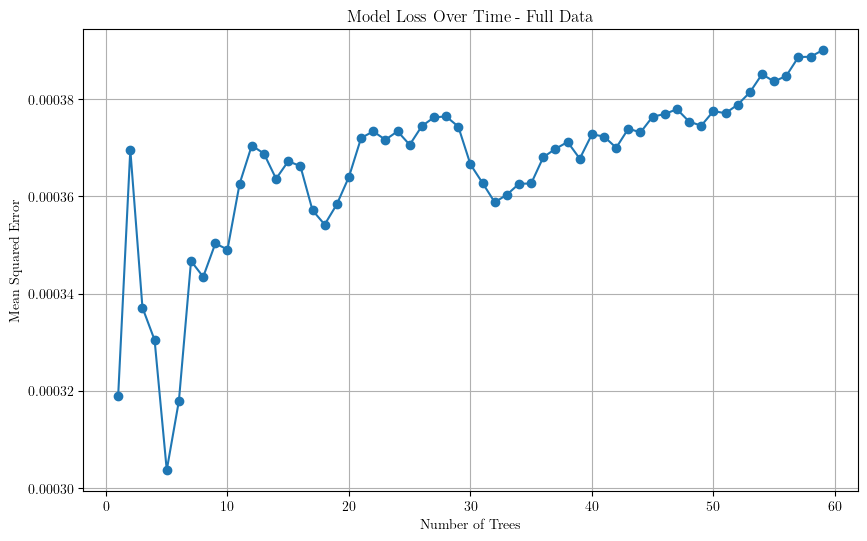

C:\Users\alith\AppData\Local\Temp\ipykernel_314948\165944086.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


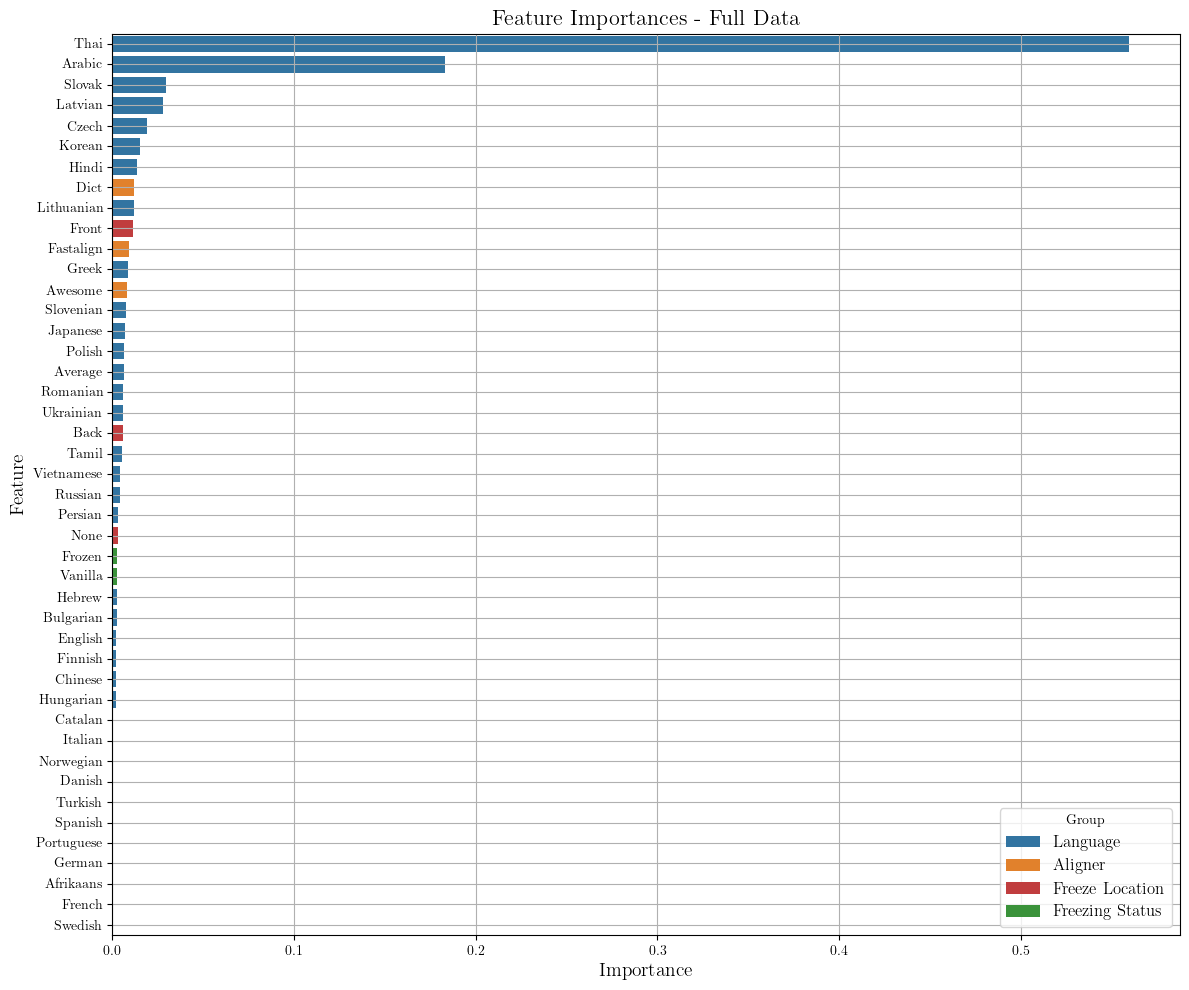

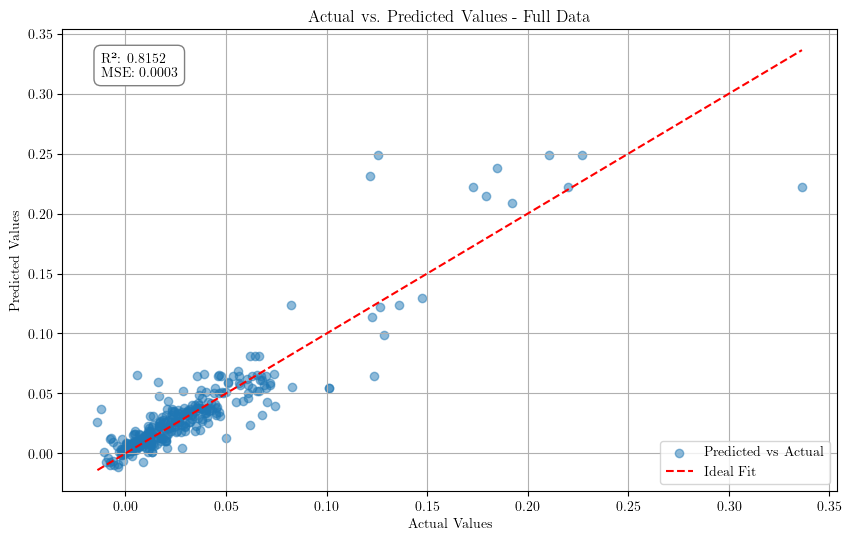

Unique feature names:
['language_Afrikaans' 'language_Arabic' 'language_Average'
 'language_Bulgarian' 'language_Catalan' 'language_Chinese'
 'language_Czech' 'language_Danish' 'language_English' 'language_Finnish'
 'language_French' 'language_German' 'language_Greek' 'language_Hebrew'
 'language_Hindi' 'language_Hungarian' 'language_Italian'
 'language_Japanese' 'language_Korean' 'language_Latvian'
 'language_Lithuanian' 'language_Norwegian' 'language_Persian'
 'language_Polish' 'language_Portuguese' 'language_Romanian'
 'language_Russian' 'language_Slovak' 'language_Slovenian'
 'language_Spanish' 'language_Swedish' 'language_Tamil' 'language_Thai'
 'language_Turkish' 'language_Ukrainian' 'language_Vietnamese'
 'aligner_Awesome' 'aligner_Dict' 'aligner_FastAlign'
 'frozen_status_Frozen' 'frozen_status_Vanilla' 'freeze_location_Back'
 'freeze_location_Front' 'freeze_location_None']

Unique groups:
['Language' 'Aligner' 'Freezing Status' 'Freeze Location']


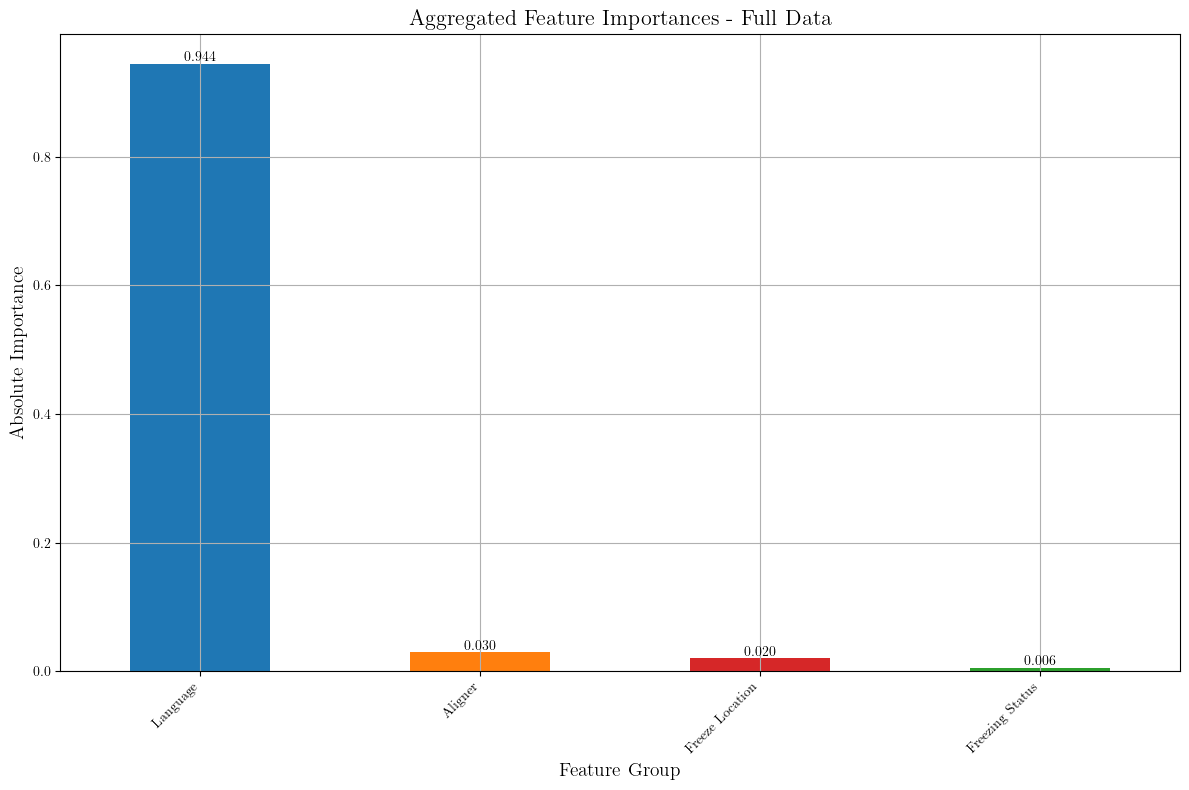


Ranked Aggregated Feature Importances - Full Data
 Rank           Group  Importance
    1        Language    0.944212
    2         Aligner    0.029602
    3 Freeze Location    0.020471
    4 Freezing Status    0.005715

Ranked Individual Feature Importances - Full Data
 Rank               Feature           Group  Importance
    1         language_Thai        Language    0.559500
    2       language_Arabic        Language    0.183019
    3       language_Slovak        Language    0.029692
    4      language_Latvian        Language    0.027865
    5        language_Czech        Language    0.018934
    6       language_Korean        Language    0.015464
    7        language_Hindi        Language    0.013448
    8          aligner_Dict         Aligner    0.012245
    9   language_Lithuanian        Language    0.012213
   10 freeze_location_Front Freeze Location    0.011587
   11     aligner_FastAlign         Aligner    0.009074
   12        language_Greek        Language    0.008592


In [22]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='Full Data')

print("Feature Importances:")
print(coefficients)

In [23]:
train_data[train_data['language'] == 'Thai']

,language,delta_accuracy,aligner,frozen_status,freeze_location
616,Thai,0.218030,Awesome,Frozen,Front
2667,Thai,0.278546,FastAlign,Frozen,Front
1293,Thai,0.142160,FastAlign,Vanilla,None
1992,Thai,0.175820,FastAlign,Frozen,Back
1300,Thai,0.124927,Awesome,Frozen,Front
3345,Thai,0.192874,FastAlign,Vanilla,None
617,Thai,0.204333,Dict,Frozen,Front
611,Thai,0.239381,Dict,Vanilla,None
2669,Thai,0.294257,Dict,Frozen,Front
2677,Thai,0.314041,Awesome,Frozen,Back


In [24]:
val_data[val_data['language'] == 'Thai']

,language,delta_accuracy,aligner,frozen_status,freeze_location
1984,Thai,0.198380,Awesome,Frozen,Front
2661,Thai,0.297211,FastAlign,Vanilla,None
3352,Thai,0.157916,Awesome,Frozen,Front
1299,Thai,0.105322,FastAlign,Frozen,Front
3351,Thai,0.150933,FastAlign,Frozen,Front


In [25]:
test_data[test_data['language'] == 'Thai']

,language,delta_accuracy,aligner,frozen_status,freeze_location
3360,Thai,0.192158,FastAlign,Frozen,Back
3353,Thai,0.179356,Dict,Frozen,Front
1310,Thai,0.172687,Dict,Frozen,Back
610,Thai,0.227116,Awesome,Vanilla,None
1994,Thai,0.219820,Dict,Frozen,Back
1294,Thai,0.125599,Awesome,Vanilla,None
2678,Thai,0.336332,Dict,Frozen,Back
1978,Thai,0.210331,Awesome,Vanilla,None
1983,Thai,0.184683,FastAlign,Frozen,Front
1309,Thai,0.121749,Awesome,Frozen,Back


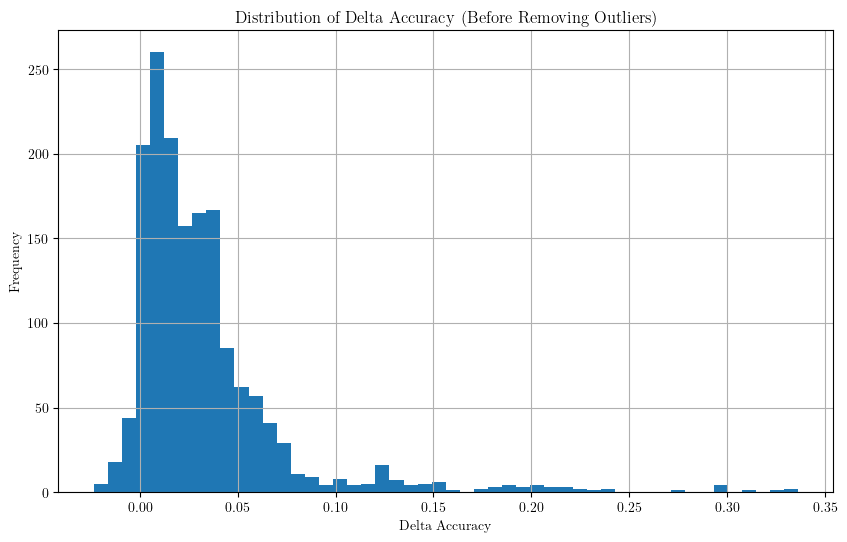

Number of outliers removed: 104
Shape of data before removing outliers: (1620, 5)
Shape of data after removing outliers: (1516, 5)


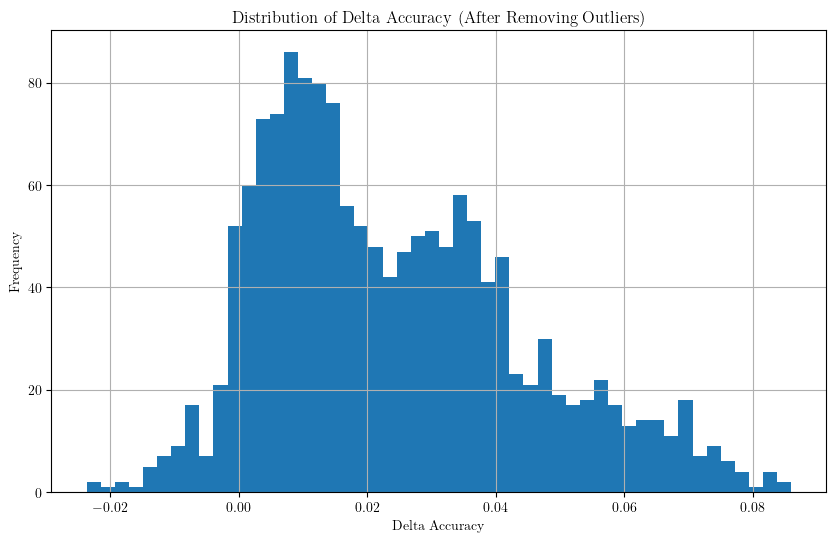


Statistics before removing outliers:
count    1620.000000
mean        0.032636
std         0.041388
min        -0.023672
25%         0.008841
50%         0.022486
75%         0.040444
max         0.336332
Name: delta_accuracy, dtype: float64

Statistics after removing outliers:
count    1516.000000
mean        0.024010
std         0.020290
min        -0.023672
25%         0.008224
50%         0.019972
75%         0.036458
max         0.086011
Name: delta_accuracy, dtype: float64

Outlier Analysis:

Top 10 Languages in Outliers:
language
Thai          45
Arabic        41
Latvian        9
Korean         4
Hindi          3
Lithuanian     2
Name: count, dtype: int64

Word Aligners in Outliers:
aligner
Dict         38
FastAlign    33
Awesome      33
Name: count, dtype: int64

Freezing Status in Outliers:
frozen_status
Frozen     67
Vanilla    37
Name: count, dtype: int64

Freeze Location in Outliers:
freeze_location
None     37
Back     35
Front    32
Name: count, dtype: int64

Top 10 High

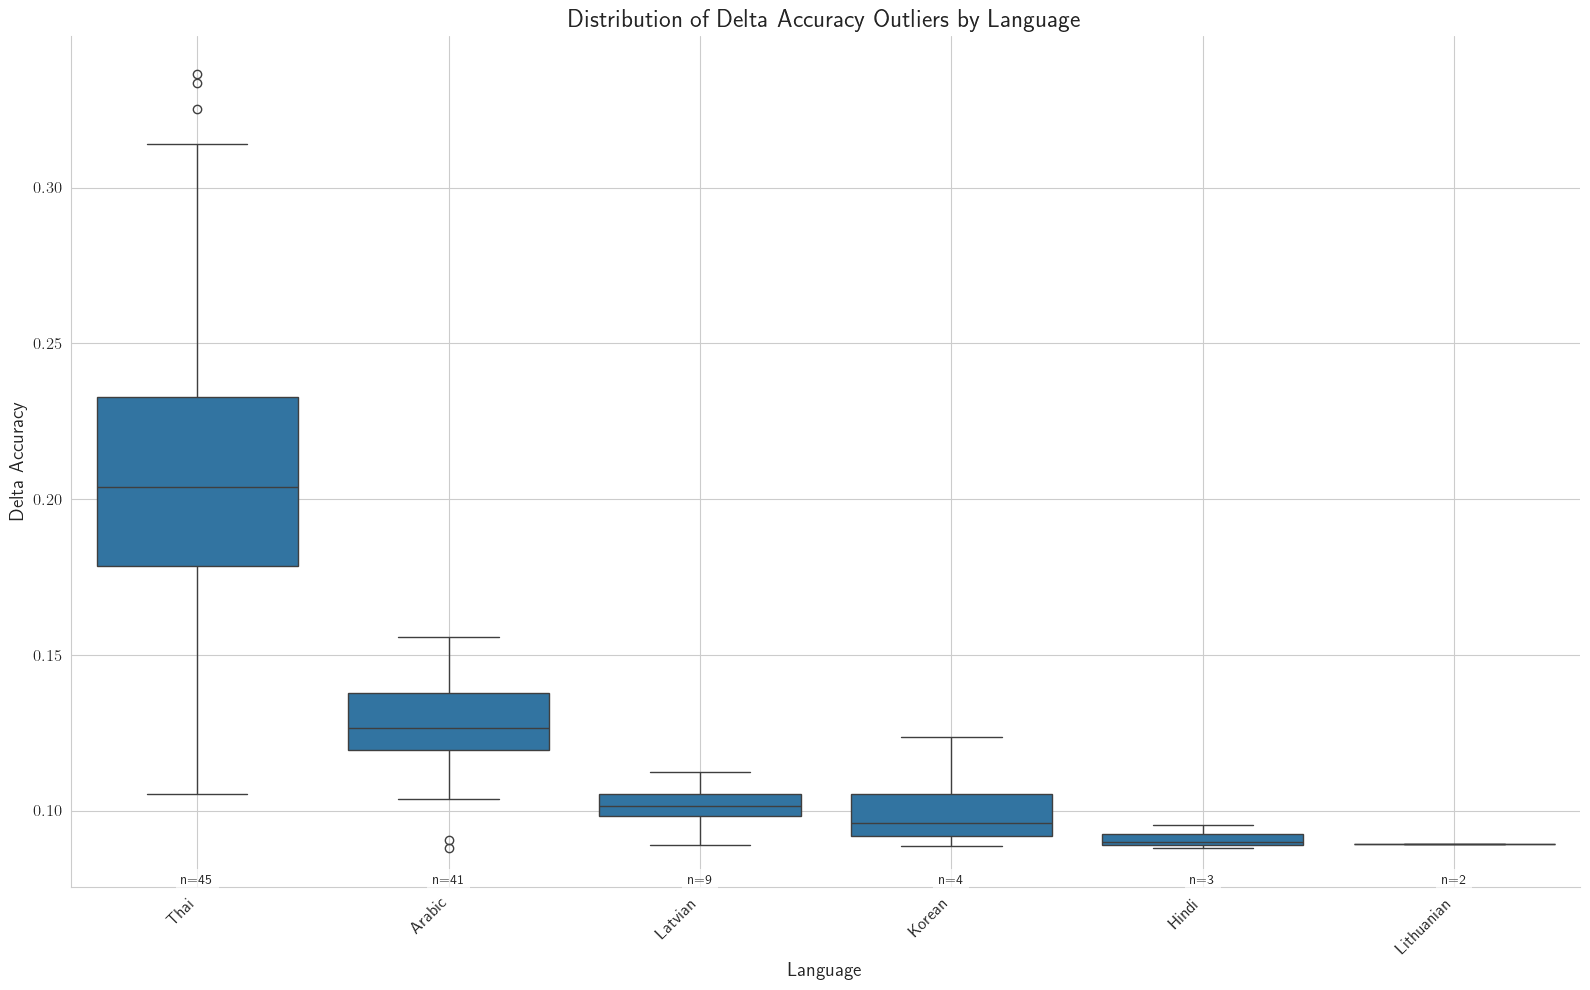


Summary Statistics for Outliers:
            count      mean       std       min       25%       50%       75%  \
language                                                                        
Arabic       41.0  0.127935  0.016026  0.087999  0.119298  0.126564  0.137712   
Hindi         3.0  0.091119  0.003758  0.088061  0.089021  0.089980  0.092647   
Korean        4.0  0.101075  0.015564  0.088550  0.091954  0.096129  0.105250   
Latvian       9.0  0.101255  0.007377  0.089045  0.098429  0.101368  0.105400   
Lithuanian    2.0  0.089325  0.000130  0.089233  0.089279  0.089325  0.089371   
Thai         45.0  0.210178  0.059681  0.105322  0.178461  0.203930  0.232756   

                 max  
language              
Arabic      0.155721  
Hindi       0.095315  
Korean      0.123491  
Latvian     0.112484  
Lithuanian  0.089417  
Thai        0.336332  


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def remove_outliers(df, column='delta_accuracy', threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean, outliers

# Before removing outliers
plt.figure(figsize=(10, 6))
plt.hist(df['delta_accuracy'], bins=50)
plt.title('Distribution of Delta Accuracy (Before Removing Outliers)')
plt.xlabel('Delta Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Remove outliers
df_clean, outliers = remove_outliers(df)

print(f"Number of outliers removed: {len(outliers)}")
print(f"Shape of data before removing outliers: {df.shape}")
print(f"Shape of data after removing outliers: {df_clean.shape}")

# After removing outliers
plt.figure(figsize=(10, 6))
plt.hist(df_clean['delta_accuracy'], bins=50)
plt.title('Distribution of Delta Accuracy (After Removing Outliers)')
plt.xlabel('Delta Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display some statistics
print("\nStatistics before removing outliers:")
print(df['delta_accuracy'].describe())
print("\nStatistics after removing outliers:")
print(df_clean['delta_accuracy'].describe())

# Analyze outliers
print("\nOutlier Analysis:")

# Languages
print("\nTop 10 Languages in Outliers:")
language_counts = outliers['language'].value_counts()
print(language_counts.head(10))

# Word Aligners
print("\nWord Aligners in Outliers:")
aligner_counts = outliers['aligner'].value_counts()
print(aligner_counts)

# Freezing Status
print("\nFreezing Status in Outliers:")
freeze_counts = outliers['frozen_status'].value_counts()
print(freeze_counts)

# Freeze Location
print("\nFreeze Location in Outliers:")
location_counts = outliers['freeze_location'].value_counts()
print(location_counts)

# Consolidated view of extreme outliers
print("\nTop 10 Highest Delta Accuracy Outliers:")
print(outliers.sort_values('delta_accuracy', ascending=False).head(10)[['language', 'aligner', 'frozen_status', 'freeze_location', 'delta_accuracy']])

print("\nTop 10 Lowest Delta Accuracy Outliers:")
print(outliers.sort_values('delta_accuracy', ascending=True).head(10)[['language', 'aligner', 'frozen_status', 'freeze_location', 'delta_accuracy']])

# Percentage of outliers by category
def percentage_outliers(feature):
    total = len(df[feature].unique())
    outlier = len(outliers[feature].unique())
    return (outlier / total) * 100

print("\nPercentage of categories that appear in outliers:")
print(f"Languages: {percentage_outliers('language'):.2f}%")
print(f"Aligners: {percentage_outliers('aligner'):.2f}%")
print(f"Freezing Status: {percentage_outliers('frozen_status'):.2f}%")
print(f"Freeze Location: {percentage_outliers('freeze_location'):.2f}%")

# Visualize outliers distribution
plt.figure(figsize=(16, 10))  # Increased figure size for better readability
sns.set_style("whitegrid")  # Add a light grid for better readability

# Sort languages by median delta accuracy
language_order = outliers.groupby('language')['delta_accuracy'].median().sort_values(ascending=False).index

# Create the boxplot
ax = sns.boxplot(x='language', y='delta_accuracy', data=outliers, order=language_order)

plt.title('Distribution of Delta Accuracy Outliers by Language', fontsize=18)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Delta Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add number of outliers for each language inside the plot
for i, language in enumerate(language_order):
    count = outliers[outliers['language'] == language].shape[0]
    plt.text(i, plt.ylim()[0], f'n={count}', ha='center', va='bottom', fontsize=10, 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Remove top and right spines
sns.despine()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Outliers:")
print(outliers.groupby('language')['delta_accuracy'].describe())

# Uncomment and modify this section if you want to visualize other features
# for feature in ['aligner', 'frozen_status', 'freeze_location']:
#     plt.figure(figsize=(12, 6))
#     sns.boxplot(x=feature, y='delta_accuracy', data=outliers, 
#                 order=outliers.groupby(feature)['delta_accuracy'].median().sort_values(ascending=False).index)
#     plt.title(f'Distribution of Outliers by {feature.replace("_", " ").title()}')
#     plt.xlabel(feature.replace("_", " ").title())
#     plt.ylabel('Delta Accuracy')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()

In [27]:
train_data, val_data, test_data = split_train_val_test(df_clean)

train_data

,language,delta_accuracy,aligner,frozen_status,freeze_location
307,Italian,0.008786,Dict,Vanilla,None
2137,Catalan,0.013702,Dict,Frozen,Front
1517,Danish,-0.000798,FastAlign,Frozen,Back
634,Turkish,0.007198,FastAlign,Frozen,Front
3270,Slovenian,0.041980,Awesome,Vanilla,None
...,...,...,...,...,...
2849,Chinese,0.020313,Dict,Frozen,Back
103,Chinese,0.011322,Awesome,Frozen,Front
2230,Finnish,0.029008,FastAlign,Frozen,Front
1128,Polish,0.030561,FastAlign,Frozen,Front


100%|██████████| 59/59 [00:00<00:00, 235.75it/s]



Final Test MSE for Outliers Removed (Random Forest): 0.00011997576102764424


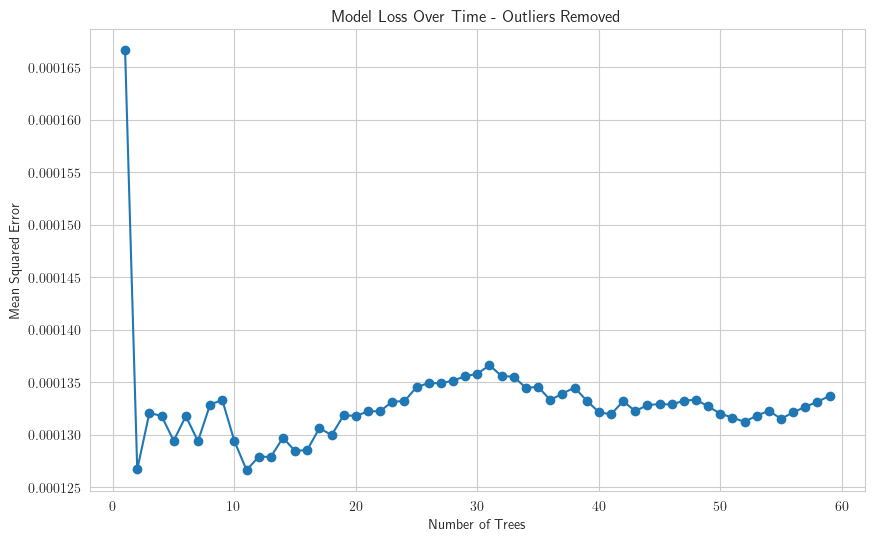

C:\Users\alith\AppData\Local\Temp\ipykernel_314948\165944086.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


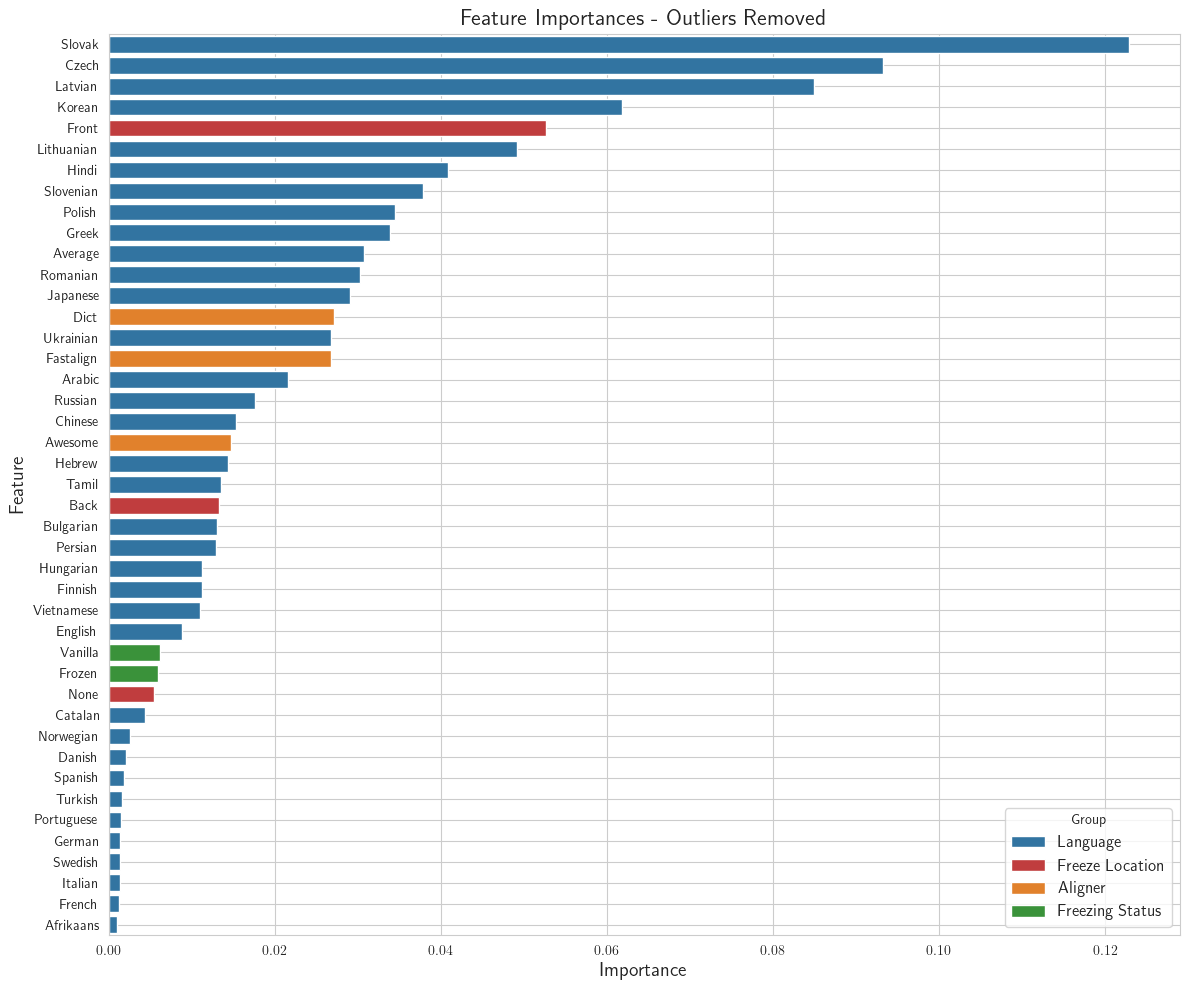

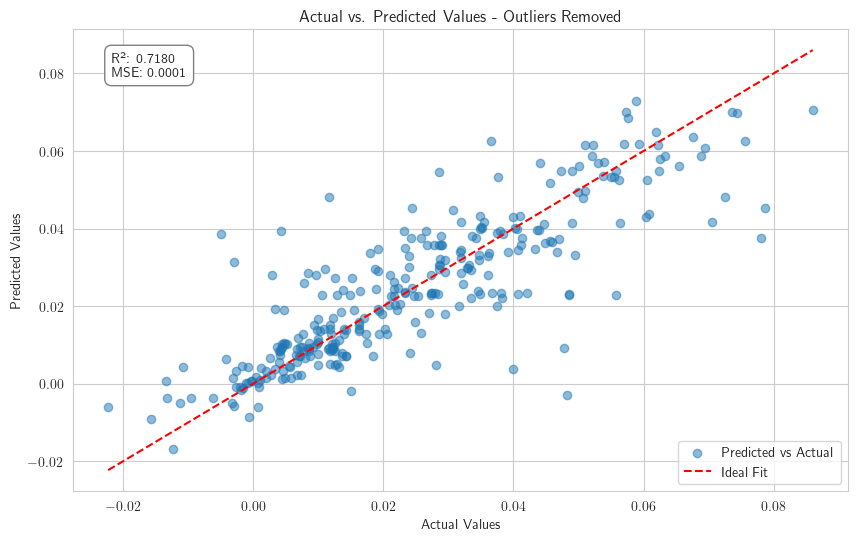

Unique feature names:
['language_Afrikaans' 'language_Arabic' 'language_Average'
 'language_Bulgarian' 'language_Catalan' 'language_Chinese'
 'language_Czech' 'language_Danish' 'language_English' 'language_Finnish'
 'language_French' 'language_German' 'language_Greek' 'language_Hebrew'
 'language_Hindi' 'language_Hungarian' 'language_Italian'
 'language_Japanese' 'language_Korean' 'language_Latvian'
 'language_Lithuanian' 'language_Norwegian' 'language_Persian'
 'language_Polish' 'language_Portuguese' 'language_Romanian'
 'language_Russian' 'language_Slovak' 'language_Slovenian'
 'language_Spanish' 'language_Swedish' 'language_Tamil' 'language_Turkish'
 'language_Ukrainian' 'language_Vietnamese' 'aligner_Awesome'
 'aligner_Dict' 'aligner_FastAlign' 'frozen_status_Frozen'
 'frozen_status_Vanilla' 'freeze_location_Back' 'freeze_location_Front'
 'freeze_location_None']

Unique groups:
['Language' 'Aligner' 'Freezing Status' 'Freeze Location']


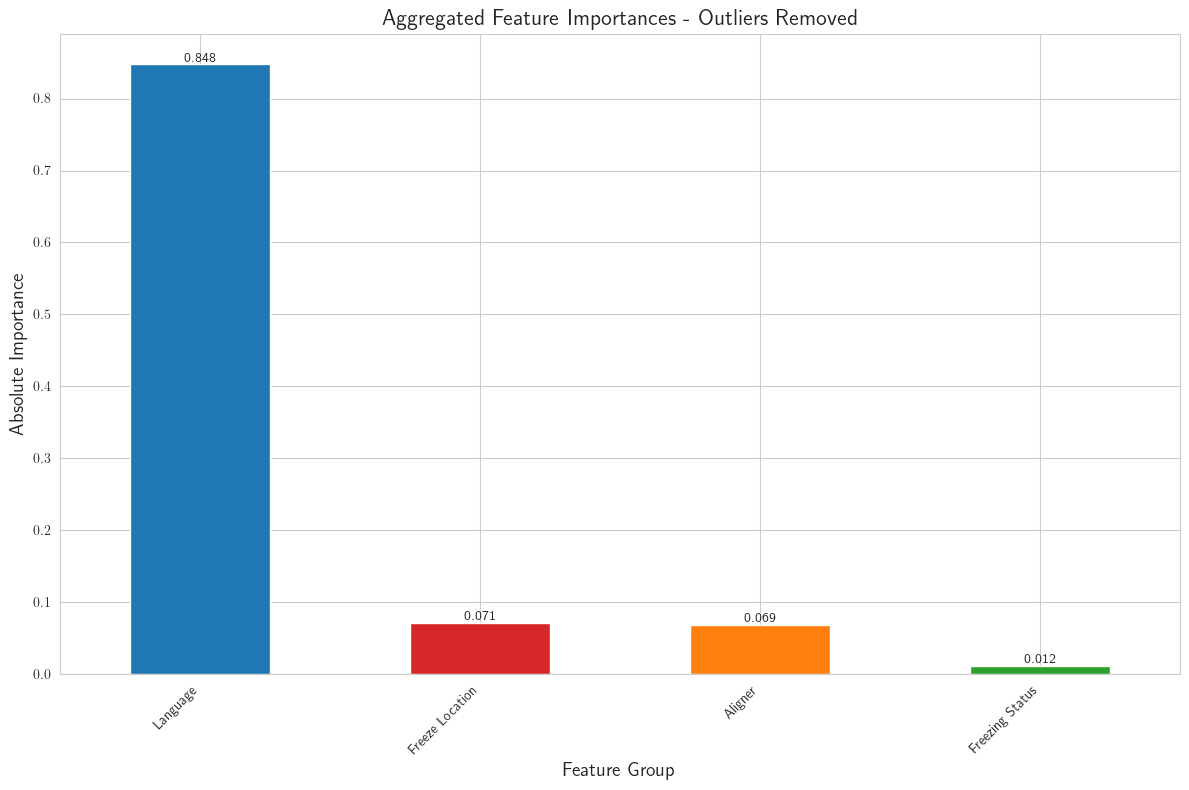


Ranked Aggregated Feature Importances - Outliers Removed
 Rank           Group  Importance
    1        Language    0.847702
    2 Freeze Location    0.071380
    3         Aligner    0.068774
    4 Freezing Status    0.012143

Ranked Individual Feature Importances - Outliers Removed
 Rank               Feature           Group  Importance
    1       language_Slovak        Language    0.122909
    2        language_Czech        Language    0.093331
    3      language_Latvian        Language    0.084947
    4       language_Korean        Language    0.061846
    5 freeze_location_Front Freeze Location    0.052649
    6   language_Lithuanian        Language    0.049228
    7        language_Hindi        Language    0.040881
    8    language_Slovenian        Language    0.037849
    9       language_Polish        Language    0.034475
   10        language_Greek        Language    0.033884
   11      language_Average        Language    0.030775
   12     language_Romanian        Languag

In [28]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='Outliers Removed')

print("Feature Importances:")
print(coefficients)

In [29]:
import warnings

# Suppress all pandas warnings
warnings.filterwarnings("ignore", module="pandas")

# linguistic_features = {
#     'Afrikaans': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Arabic': {'script_type': 'Abjad', 'word_order': 'VSO', 'morphological_complexity': 'High'},
#     'Bulgarian': {'script_type': 'Cyrillic', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Catalan': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Chinese': {'script_type': 'Chinese', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Czech': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Danish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'English': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Finnish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'French': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'German': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Greek': {'script_type': 'Greek', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Hebrew': {'script_type': 'Abjad', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Hindi': {'script_type': 'Devanagari', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Hungarian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Italian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Japanese': {'script_type': 'Japanese', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Korean': {'script_type': 'Hangul', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Latvian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Lithuanian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Norwegian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Persian': {'script_type': 'Arabic', 'word_order': 'SOV', 'morphological_complexity': 'Medium'},
#     'Polish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Portuguese': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Romanian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Russian': {'script_type': 'Cyrillic', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Slovak': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Slovenian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Spanish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Swedish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Tamil': {'script_type': 'Abugida', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Thai': {'script_type': 'Abugida', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Turkish': {'script_type': 'Latin', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Ukrainian': {'script_type': 'Cyrillic', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Vietnamese': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'}
# }


linguistic_features = {
    'Afrikaans': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Arabic': {'script_type': 'Abjad', 'word_order': 'VSO'},
    'Bulgarian': {'script_type': 'Cyrillic', 'word_order': 'SVO'},
    'Catalan': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Chinese': {'script_type': 'Chinese', 'word_order': 'SVO'},
    'Czech': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Danish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'English': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Finnish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'French': {'script_type': 'Latin', 'word_order': 'SVO'},
    'German': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Greek': {'script_type': 'Greek', 'word_order': 'SVO'},
    'Hebrew': {'script_type': 'Abjad', 'word_order': 'SVO'},
    'Hindi': {'script_type': 'Devanagari', 'word_order': 'SOV'},
    'Hungarian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Italian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Japanese': {'script_type': 'Japanese', 'word_order': 'SOV'},
    'Korean': {'script_type': 'Hangul', 'word_order': 'SOV'},
    'Latvian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Lithuanian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Norwegian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Persian': {'script_type': 'Arabic', 'word_order': 'SOV'},
    'Polish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Portuguese': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Romanian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Russian': {'script_type': 'Cyrillic', 'word_order': 'SVO'},
    'Slovak': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Slovenian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Spanish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Swedish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Tamil': {'script_type': 'Abugida', 'word_order': 'SOV'},
    'Thai': {'script_type': 'Abugida', 'word_order': 'SVO'},
    'Turkish': {'script_type': 'Latin', 'word_order': 'SOV'},
    'Ukrainian': {'script_type': 'Cyrillic', 'word_order': 'SVO'},
    'Vietnamese': {'script_type': 'Latin', 'word_order': 'SVO'}
}

def add_linguistic_features(df):
    df = df.copy()
    df['script_type'] = df['language'].map(lambda x: linguistic_features.get(x, {}).get('script_type'))
    df['word_order'] = df['language'].map(lambda x: linguistic_features.get(x, {}).get('word_order'))
    df['morphological_complexity'] = df['language'].map(lambda x: linguistic_features.get(x, {}).get('morphological_complexity'))
    return df


In [30]:
df_clean = add_linguistic_features(df_clean)

In [31]:
df_clean = add_language_distances_to_df(df_clean)

Error: Average is not in the language mapping.


In [32]:
train_data, val_data, test_data = split_train_val_test(df_clean)

100%|██████████| 59/59 [00:00<00:00, 162.47it/s]



Final Test MSE for Outliers Removed (Random Forest): 0.00012112098720783244


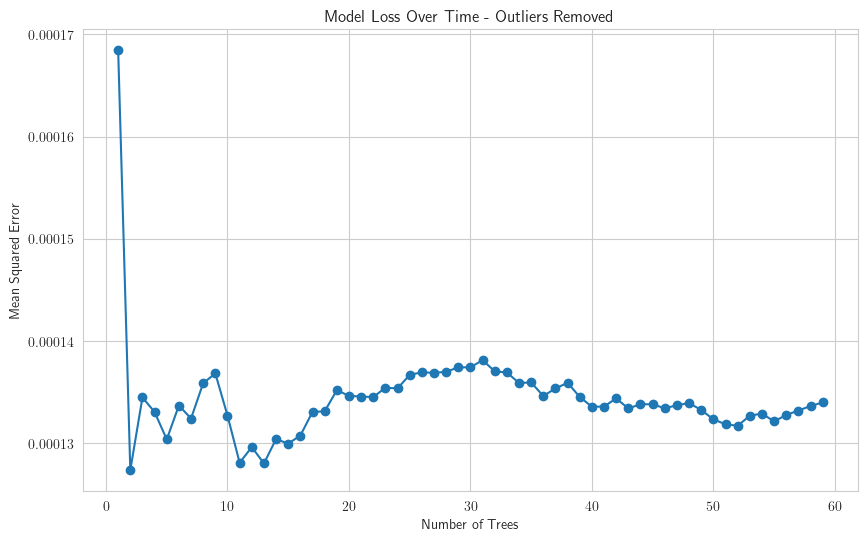

C:\Users\alith\AppData\Local\Temp\ipykernel_314948\165944086.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


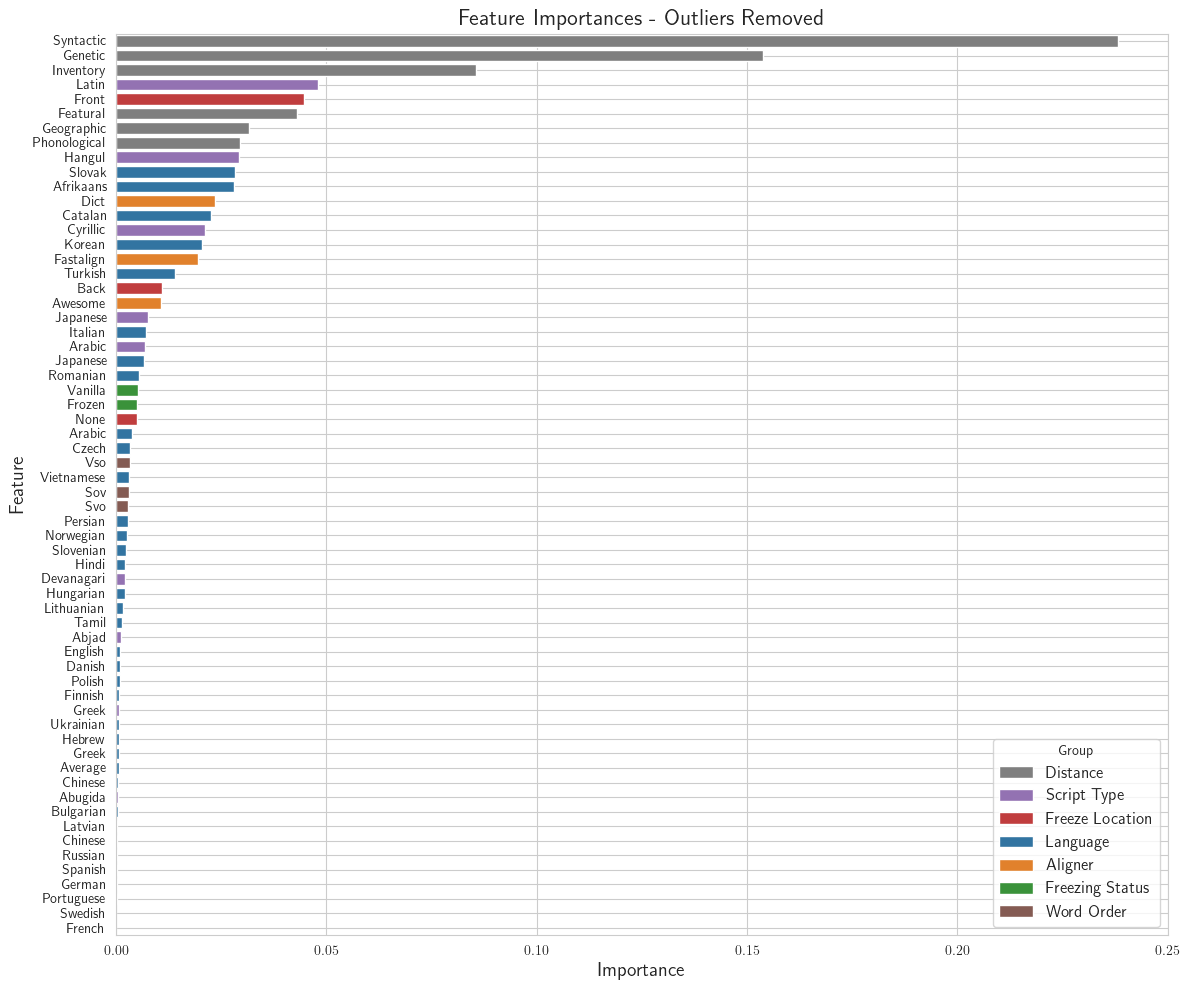

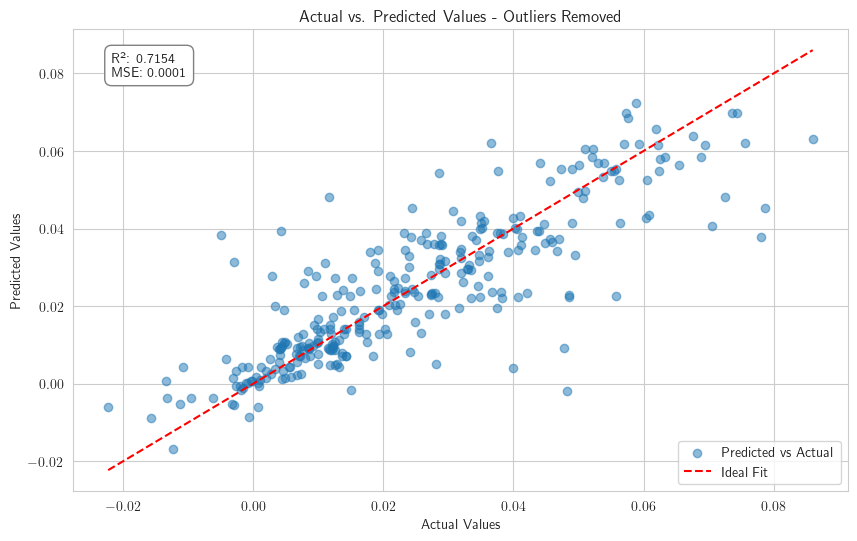

Unique feature names:
['syntactic' 'geographic' 'phonological' 'genetic' 'inventory' 'featural'
 'language_Afrikaans' 'language_Arabic' 'language_Average'
 'language_Bulgarian' 'language_Catalan' 'language_Chinese'
 'language_Czech' 'language_Danish' 'language_English' 'language_Finnish'
 'language_French' 'language_German' 'language_Greek' 'language_Hebrew'
 'language_Hindi' 'language_Hungarian' 'language_Italian'
 'language_Japanese' 'language_Korean' 'language_Latvian'
 'language_Lithuanian' 'language_Norwegian' 'language_Persian'
 'language_Polish' 'language_Portuguese' 'language_Romanian'
 'language_Russian' 'language_Slovak' 'language_Slovenian'
 'language_Spanish' 'language_Swedish' 'language_Tamil' 'language_Turkish'
 'language_Ukrainian' 'language_Vietnamese' 'aligner_Awesome'
 'aligner_Dict' 'aligner_FastAlign' 'frozen_status_Frozen'
 'frozen_status_Vanilla' 'freeze_location_Back' 'freeze_location_Front'
 'freeze_location_None' 'script_type_Abjad' 'script_type_Abugida'
 'scri

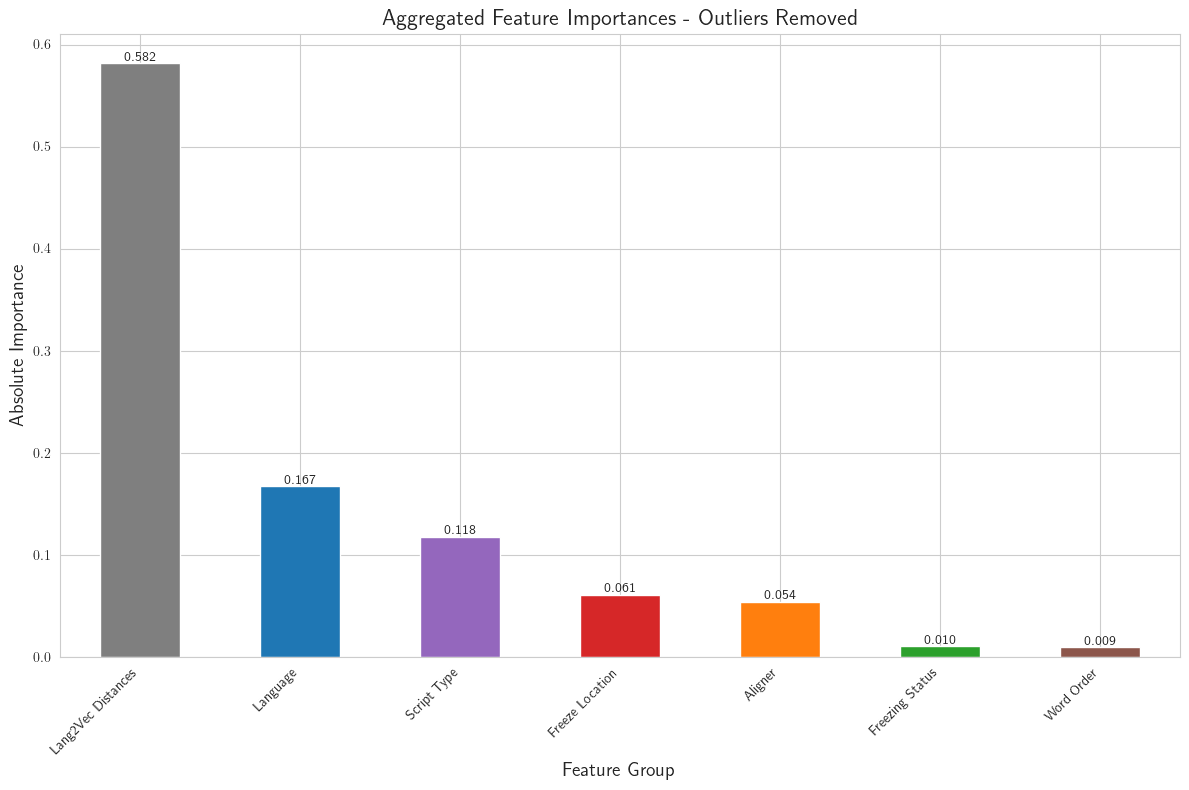


Ranked Aggregated Feature Importances - Outliers Removed
 Rank              Group  Importance
    1 Lang2Vec Distances    0.581602
    2           Language    0.166972
    3        Script Type    0.117756
    4    Freeze Location    0.060532
    5            Aligner    0.053772
    6    Freezing Status    0.010167
    7         Word Order    0.009200

Ranked Individual Feature Importances - Outliers Removed
 Rank               Feature              Group  Importance
    1             syntactic Lang2Vec Distances    0.238137
    2               genetic Lang2Vec Distances    0.153691
    3             inventory Lang2Vec Distances    0.085639
    4     script_type_Latin        Script Type    0.047955
    5 freeze_location_Front    Freeze Location    0.044586
    6              featural Lang2Vec Distances    0.043008
    7            geographic Lang2Vec Distances    0.031555
    8          phonological Lang2Vec Distances    0.029572
    9    script_type_Hangul        Script Type    0.02924

In [33]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='Outliers Removed')

print("Feature Importances:")
print(coefficients)

In [34]:
df = add_language_distances_to_df(df)
df = add_linguistic_features(df)

train_data, val_data, test_data = split_train_val_test(df)

Error: Average is not in the language mapping.


100%|██████████| 59/59 [00:00<00:00, 175.51it/s]



Final Test MSE for All Data (Random Forest): 0.00030139641286944653


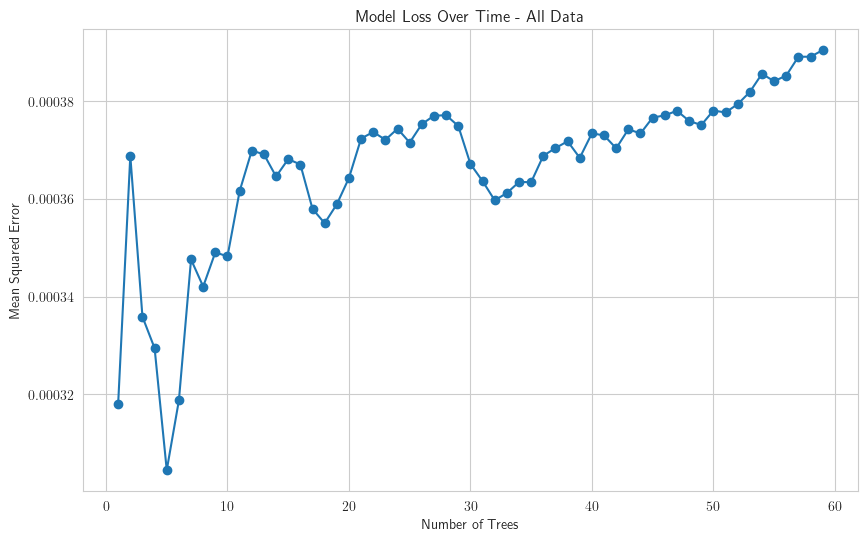

C:\Users\alith\AppData\Local\Temp\ipykernel_314948\165944086.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


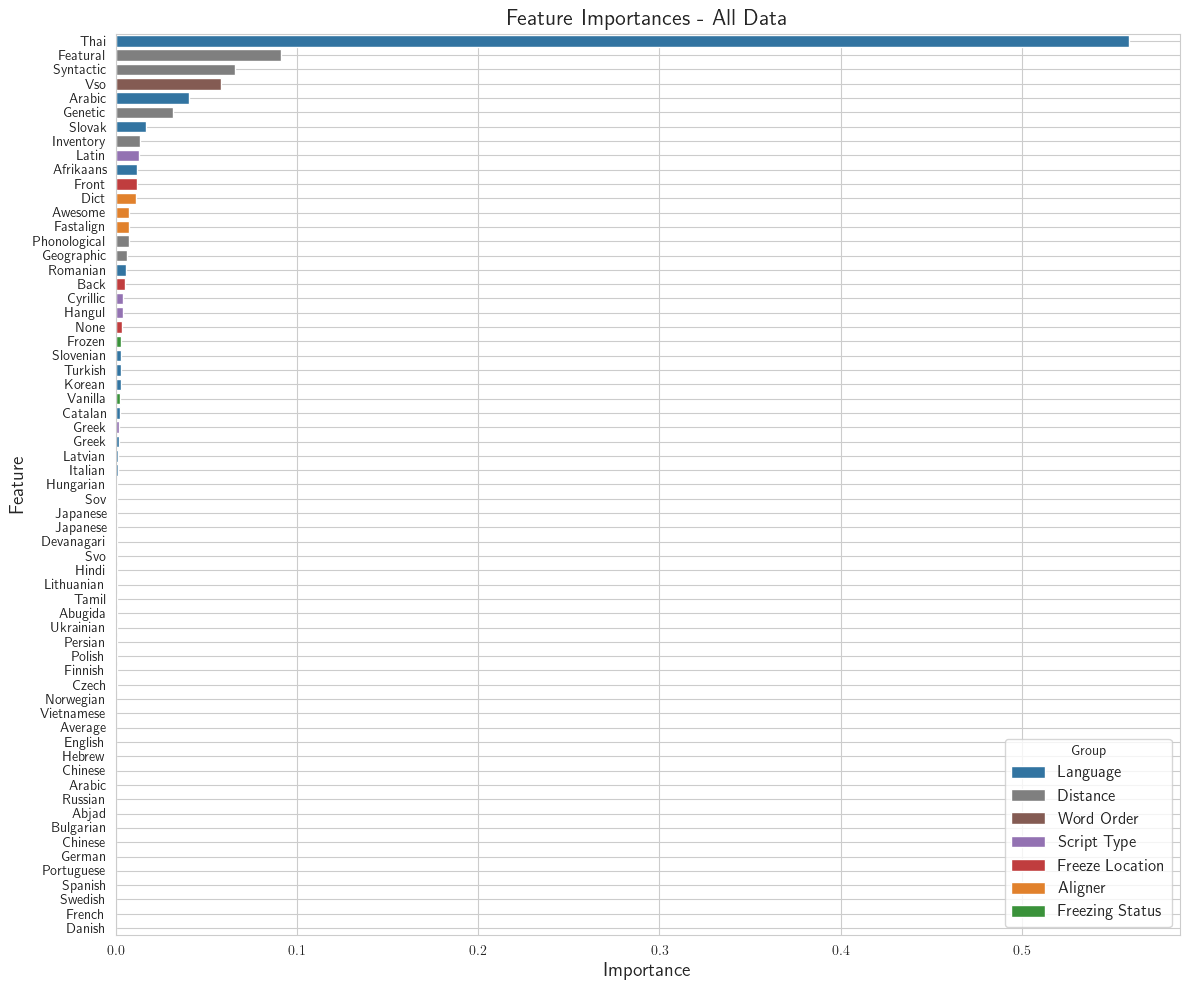

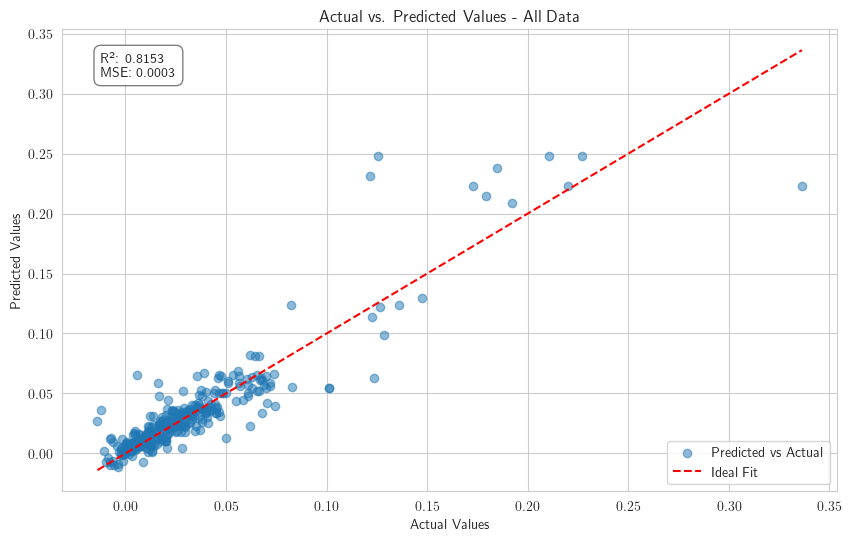

Unique feature names:
['syntactic' 'geographic' 'phonological' 'genetic' 'inventory' 'featural'
 'language_Afrikaans' 'language_Arabic' 'language_Average'
 'language_Bulgarian' 'language_Catalan' 'language_Chinese'
 'language_Czech' 'language_Danish' 'language_English' 'language_Finnish'
 'language_French' 'language_German' 'language_Greek' 'language_Hebrew'
 'language_Hindi' 'language_Hungarian' 'language_Italian'
 'language_Japanese' 'language_Korean' 'language_Latvian'
 'language_Lithuanian' 'language_Norwegian' 'language_Persian'
 'language_Polish' 'language_Portuguese' 'language_Romanian'
 'language_Russian' 'language_Slovak' 'language_Slovenian'
 'language_Spanish' 'language_Swedish' 'language_Tamil' 'language_Thai'
 'language_Turkish' 'language_Ukrainian' 'language_Vietnamese'
 'aligner_Awesome' 'aligner_Dict' 'aligner_FastAlign'
 'frozen_status_Frozen' 'frozen_status_Vanilla' 'freeze_location_Back'
 'freeze_location_Front' 'freeze_location_None' 'script_type_Abjad'
 'script_typ

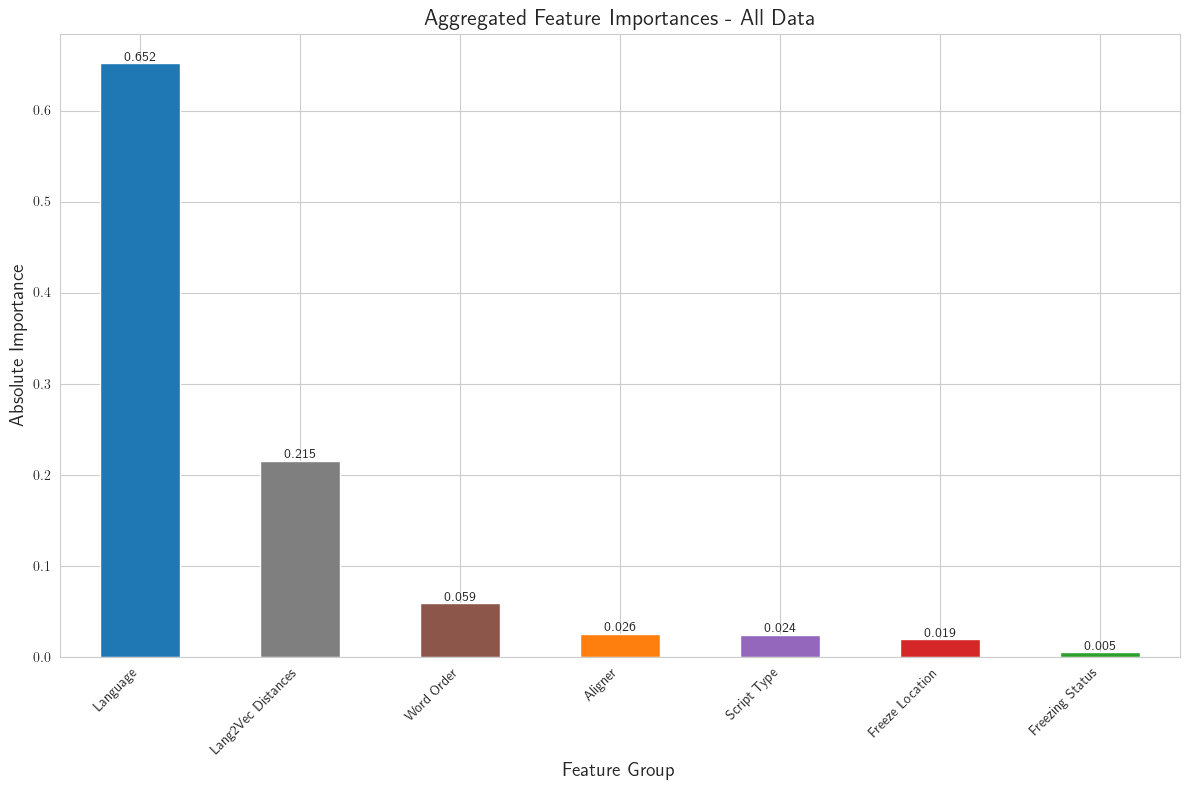


Ranked Aggregated Feature Importances - All Data
 Rank              Group  Importance
    1           Language    0.651846
    2 Lang2Vec Distances    0.214923
    3         Word Order    0.058917
    4            Aligner    0.025608
    5        Script Type    0.024395
    6    Freeze Location    0.019361
    7    Freezing Status    0.004950

Ranked Individual Feature Importances - All Data
 Rank               Feature              Group  Importance
    1         language_Thai           Language    0.559458
    2              featural Lang2Vec Distances    0.091301
    3             syntactic Lang2Vec Distances    0.065807
    4        word_order_VSO         Word Order    0.057747
    5       language_Arabic           Language    0.040392
    6               genetic Lang2Vec Distances    0.031387
    7       language_Slovak           Language    0.016293
    8             inventory Lang2Vec Distances    0.013398
    9     script_type_Latin        Script Type    0.012743
   10    langu

In [35]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='All Data')

print("Feature Importances:")
print(coefficients)

In [36]:
df[df['language'] == 'Thai'].sort_values('delta_accuracy', ascending=False)

,language,delta_accuracy,aligner,frozen_status,freeze_location,syntactic,geographic,phonological,genetic,inventory,featural,script_type,word_order,morphological_complexity
2678,Thai,0.336332,Dict,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
2663,Thai,0.333512,Dict,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
2662,Thai,0.325276,Awesome,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
2677,Thai,0.314041,Awesome,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
2668,Thai,0.297211,Awesome,Frozen,Front,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
2661,Thai,0.297211,FastAlign,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
2676,Thai,0.294884,FastAlign,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
2669,Thai,0.294257,Dict,Frozen,Front,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
2667,Thai,0.278546,FastAlign,Frozen,Front,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None
626,Thai,0.241395,Dict,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO,None


In [40]:
df_clean.groupby('language').count()

,delta_accuracy,aligner,frozen_status,freeze_location,script_type,word_order,morphological_complexity,syntactic,geographic,phonological,genetic,inventory,featural
language,,,,,,,,,,,,,
Afrikaans,45,45,45,45,45,45,0,45,45,45,45,45,45
Arabic,4,4,4,4,4,4,0,4,4,4,4,4,4
Average,45,45,45,45,0,0,0,0,0,0,0,0,0
Bulgarian,45,45,45,45,45,45,0,45,45,45,45,45,45
Catalan,45,45,45,45,45,45,0,45,45,45,45,45,45
Chinese,45,45,45,45,45,45,0,45,45,45,45,45,45
Czech,45,45,45,45,45,45,0,45,45,45,45,45,45
Danish,45,45,45,45,45,45,0,45,45,45,45,45,45
English,45,45,45,45,45,45,0,45,45,45,45,45,45


In [41]:
df_clean.head()

,language,delta_accuracy,aligner,frozen_status,freeze_location,script_type,word_order,morphological_complexity,syntactic,geographic,phonological,genetic,inventory,featural
1,Afrikaans,0.014406,FastAlign,Vanilla,None,Latin,SVO,None,0.63,0.4,0.5687,0.6,0.5144,0.6
2,Afrikaans,0.012618,Awesome,Vanilla,None,Latin,SVO,None,0.63,0.4,0.5687,0.6,0.5144,0.6
3,Afrikaans,0.002086,Dict,Vanilla,None,Latin,SVO,None,0.63,0.4,0.5687,0.6,0.5144,0.6
7,Afrikaans,0.011128,FastAlign,Frozen,Front,Latin,SVO,None,0.63,0.4,0.5687,0.6,0.5144,0.6
8,Afrikaans,0.011227,Awesome,Frozen,Front,Latin,SVO,None,0.63,0.4,0.5687,0.6,0.5144,0.6
